In [1]:
%env CUDA_VISIBLE_DEVICES=0
import torch
# import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from math import floor

import sys
sys.path.append('./pytorch_GAN_zoo/')
import hubconf

env: CUDA_VISIBLE_DEVICES=0


# define the generator and hyperparameters

In [2]:
device = 'cuda:0'


kwargs = {'model_name': 'celebAHQ-256',
          'useGPU': True}

model = hubconf.PGAN(pretrained = True, **kwargs)

# inputRandom, randomLabels = model.buildNoiseData(1)

# inputRandom.shape
nz = 512
# n = 3*512*512
n = 3*256*256


def scale( x ):
    scaling = x.max() - x.min()
    return ( x-x.min() ) /scaling

Average network found !


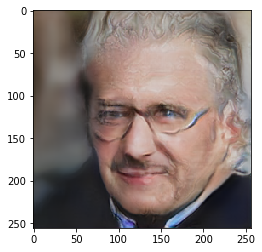

In [3]:

z0 = torch.randn(1,nz).to(device)/1.1
z0.requires_grad = False

x = model.test(z0, getAvG=True, toCPU=False)

plt.imshow(scale( x ).detach().cpu().numpy()[0].transpose(1,2,0))

In [14]:


# make a wrapper for generating from z
def gen(z_var):
    return model.test(z_var, getAvG=True, toCPU=False)

In [15]:

# # Clean data
# def data1(n_samples, x , sigma):
#     n_features = x.view(-1).size()[0]
#     A = torch.randn([n_samples, n_features], device=device)/np.sqrt(n_samples)
#     y = A.mm(x.view(-1,1)) + sigma * torch.randn([n_samples,1], device=device)
#     return y, A


# Corrupted data
def data2(n_outliers, n_features, type_outliers = 1, beta = 1, rho=1):
    if type_outliers == 1:
        Y = np.ones(n_outliers)
        X = np.ones((n_outliers, n_features))/np.sqrt(n_outliers)
    elif type_outliers == 2:
        Y = -1*torch.ones([n_outliers,1], device=device)#100*torch.ones([n_outliers,1], device=device)
        X = torch.ones([n_outliers, n_features], device=device)/np.sqrt(n_outliers)
    elif type_outliers == 3:
        Y = np.random.randint(10, size = n_outliers)
        X = np.random.rand(n_outliers, n_features)/(n_outliers)
    else:
        cov = np.identity(n_features)
        X = feature_mat(n_features, n_outliers, rho)
        Y = X.dot(beta) + sigma * randn(n_outliers)
    return Y, X


# Heavy tailed data
def data3(n_heavy_tail, x, deg = 4, noise = 4):
    n_features = x.view(-1).size()[0]
    A = torch.Tensor(np.random.standard_t(deg, size=(n_heavy_tail,n_features))).to(device)/np.sqrt(n_features)#(torch.randn([n_heavy_tail, n_features], device=device)**2)/np.sqrt(n_heavy_tail) 
    y = A.mm(x.view(-1,1)) + .15*torch.Tensor(np.random.standard_t(noise, size=(n_heavy_tail,1))).to(device)
    return y, A

def data_merge(y1, A1, y2, A2):
    y = torch.cat((y1, y2))
    A = torch.cat((A1, A2))
    return y, A


def data_creation(n_heavy_tail, n_outliers, x, deg = 4, noise = 4):
    n_features = x.view(-1).size()[0]
    A = torch.Tensor(np.random.standard_t(deg, size=(n_heavy_tail,n_features))).to(device)/np.sqrt(n_features)#(torch.randn([n_heavy_tail, n_features], device=device)**2)/np.sqrt(n_heavy_tail) 
    y = A.mm(x.view(-1,1)) + .15*torch.Tensor(np.random.standard_t(noise, size=(n_heavy_tail,1))).to(device)
    
    y[n_heavy_tail - n_outliers:] = -1*torch.ones([n_outliers,1], device=device)#100*torch.ones([n_outliers,1], device=device)
    A[n_heavy_tail - n_outliers:, :] = \
    torch.ones([n_outliers, n_features], device=device)/np.sqrt(n_outliers)
     
    return y, A



In [16]:
m_good = 1000

eta = 0.01
m_bad = floor(m_good*eta)


n_features = x.view(-1).size()[0]
print(n_features)

196608


In [17]:
y, A = data_creation(m_good+m_bad, m_bad, x, deg=4, noise=3)


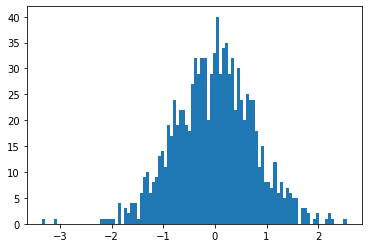

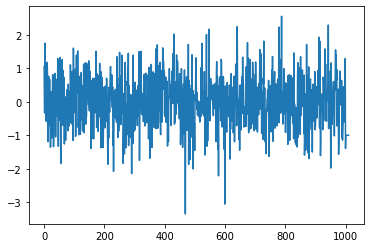

In [18]:

# # y_bad, A_bad = data2(m_bad, n_features, type_outliers=2)#data3(m_bad, x, noise_degree)

# # y, A = data_merge(y_heavy, A_heavy, y_bad, A_bad)

# # y, A = y_heavy, A_heavy

plt.hist(y.cpu().data.numpy(), bins=100)
plt.show()


plt.plot(y.cpu())


In [19]:
%load_ext autoreload
%autoreload 2

import importlib
import ERM
import Huber_gan
import mom_single_gan
import mom_gan
import trim_loss



importlib.reload(ERM)
importlib.reload(Huber_gan)
importlib.reload(trim_loss)

importlib.reload(mom_single_gan)

importlib.reload(mom_gan)

%reload_ext autoreload

import warnings
warnings.filterwarnings('ignore')

N_ITER = 5000


  0%|          | 3/5000 [00:00<03:38, 22.83it/s]

ERM


100%|██████████| 5000/5000 [03:34<00:00, 23.26it/s]


215.30361199999996
Huber
222.05449900000002


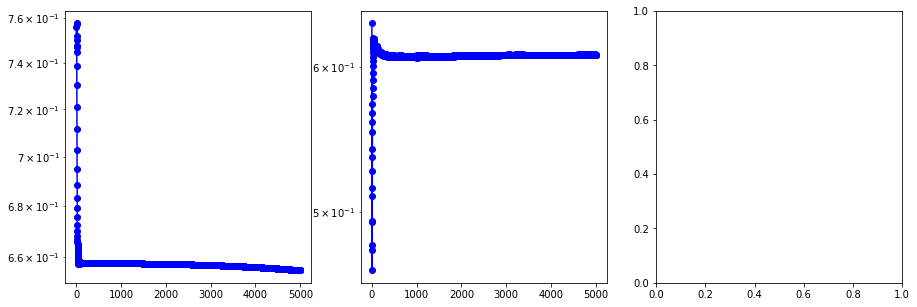

In [20]:

fig,ax = plt.subplots(1,3,figsize=(15,5))


import time

time_start = time.clock()

print("ERM")
LR = 5e-2
loss_heavy_ERM, z_heavy_ERM, time_ERM = \
ERM.ERM_estimate(gen, z0, A, y, N_ITER=N_ITER, LR=LR)

ax[0].semilogy(range(1,N_ITER+1),loss_heavy_ERM,'bo-')
time_elapsed = (time.clock() - time_start)

print(time_elapsed)


time_start = time.clock()

print("Huber")
LR = 5e-2
loss_huber, z_Huber, time_Huber = \
Huber_gan.Huber_estimate(gen, z0, A, y, N_ITER=N_ITER, LR=LR)

ax[1].semilogy(range(1,N_ITER+1),loss_huber,'bo-')
time_elapsed = (time.clock() - time_start)

print(time_elapsed)



In [224]:

time_start = time.clock()

print("trimmed loss")
LR = 5e-2
loss_trim, z_trim, time_trim = \
trim_loss.trim_estimate(gen, z0, A, y, N_ITER=N_ITER, LR=LR)

# ax[2].semilogy(range(1,N_ITER+1),loss_trim,'bo-')

time_elapsed = (time.clock() - time_start)

print(time_elapsed)


trimmed loss
0
1000
2000
3000
4000
214.09021200000007


In [16]:
f0 = gen(z0)[0].detach().cpu().numpy().transpose(1,2,0)
f1 = gen(z_heavy_ERM)[0].detach().cpu().numpy().transpose(1,2,0)
f2 = gen(z_Huber)[0].detach().cpu().numpy().transpose(1,2,0)
f3 = gen(z_trim)[0].detach().cpu().numpy().transpose(1,2,0)


NameError: name 'z_trim' is not defined

NameError: name 'f3' is not defined

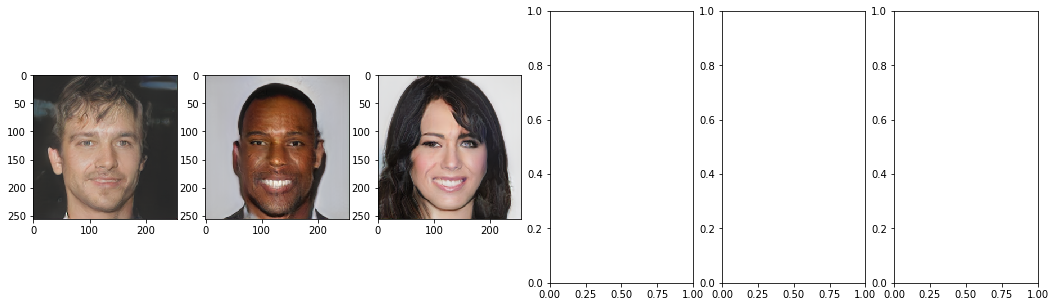

In [17]:
 
fig,ax = plt.subplots(1,6, figsize=(18,5))

ax[ 0].imshow(scale(f0),cmap='gray')
ax[ 1].imshow(scale(f1),cmap='gray')
ax[ 2].imshow(scale(f2),cmap='gray')
ax[ 3].imshow(scale(f3),cmap='gray')

# ax[0].set_title('loss function')
ax[ 0].set_title('Original ')
ax[ 1].set_title('ERM ')
ax[ 2].set_title('L1 loss minimization')
ax[ 3].set_title('Trimmed loss minimization')

plt.tight_layout()

In [227]:


time_start = time.clock()
print("MOM_single")
bs = 3
LR = 8e-2
loss_mom_single, z_mom_single, time_single = \
mom_single_gan.MOM_single_estimate(gen, z0, A, y, batch_size=bs, N_ITER=N_ITER, LR=LR)

time_elapsed = (time.clock() - time_start)

print(time_elapsed)


MOM_single
0
500
1000
1500
2000
2500
3000
3500
4000
4500
200
243.96764000000076


In [228]:

time_start = time.clock()

print("MOM tournament")
bs = 3
LR = 8e-2
loss_f, loss_g, z1_mom, z2_mom, time_mom = \
mom_gan.MOM_estimate(gen, z0, A, y, batch_size=bs, N_ITER=N_ITER, LR=LR)


if loss_f[-1] < loss_g[-1]:
    z_MOM = z1_mom
else:
    z_MOM = z2_mom
    

    

time_elapsed = (time.clock() - time_start)

print(time_elapsed)    
    

MOM tournament
0
500
1000
1500
2000
2500
3000
3500
4000
4500
622.1610120000005


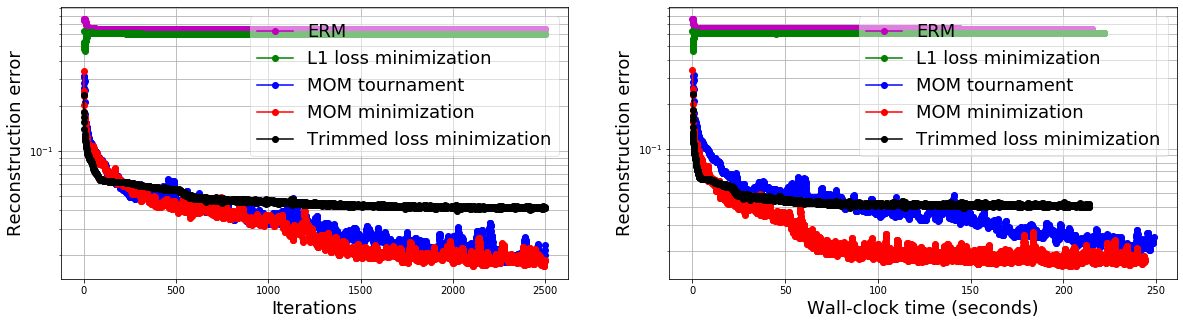

In [40]:
import pickle

filename = 'time_loss.pickle'

with open(filename, 'rb') as f:        
    loaded_obj = pickle.load(f)

fig,ax = plt.subplots(1,2,figsize=(20,5))

# ax.semilogy(loss_heavy_ERM,'yo-')

# ax.semilogy(loss_huber,'co-')
length = 2500


ax[0].semilogy(loss_heavy_ERM[:length],'mo-', label='ERM')

ax[0].semilogy(loss_huber[:length],'go-', label='L1 loss minimization')

ax[0].semilogy(loaded_obj['loss_f'][:length],'bo-', label='MOM tournament')

ax[0].semilogy(loaded_obj['loss_mom_single'][:length],'ro-', label='MOM minimization')

ax[0].semilogy(loaded_obj['loss_trim'][:length],\
'ko-', label='Trimmed loss minimization')


ax[0].set_ylabel("Reconstruction error", fontsize=18)
ax[0].set_xlabel("Iterations", fontsize=18)

ax[0].legend(loc='upper right',fontsize=18, framealpha=0.5)

ax[0].grid(which='both')




ax[1].semilogy(time_ERM, loss_heavy_ERM,'mo-', label='ERM')

ax[1].semilogy(time_Huber, loss_huber,'go-', label='L1 loss minimization')


ax[1].semilogy(loaded_obj['time_mom'][:length-500], \
               loaded_obj['loss_f'][:length-500],'bo-', label='MOM tournament')

ax[1].semilogy(loaded_obj['time_single'], \
            loaded_obj['loss_mom_single'],'ro-', label='MOM minimization')

ax[1].semilogy(loaded_obj['time_trim'], loaded_obj['loss_trim'],\
'ko-', label='Trimmed loss minimization')

ax[1].set_ylabel("Reconstruction error", fontsize=18)
ax[1].set_xlabel("Wall-clock time (seconds)", fontsize=18)



ax[1].legend(loc='upper right',fontsize=18, framealpha=0.5)


ax[1].grid(which='both')

# ax.semilogy(time_single, loss_mom_single,'ro-', label='MOM minimization')
# # plt.ylim([1e-2, 1])

# # ax.semilogy(loss_g,'co-')
# ax.semilogy(time_trim, loss_trim,'ko-', label='Trimmed loss minimization')


# ax[2].semilogy(loss_g.detach(),'bo-')
# plt.ylim([1e-2, .5])




plt.plot()

fig.savefig("Time_Loss_NIPS.pdf", bbox_inches='tight')


In [231]:
import pickle
some_obj = {"time_mom":time_mom,
            "time_single": time_single,
            "time_trim":time_trim,
            'loss_f':loss_f, 
            'loss_mom_single':loss_mom_single,
            'loss_trim':loss_trim                      
           }

with open('time_loss.pickle', 'wb') as f:
    pickle.dump(some_obj, f)

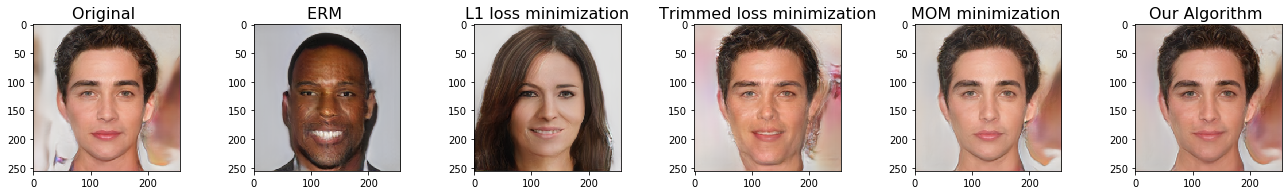

In [230]:
f4 = gen(z_mom_single)[0].detach().cpu().numpy().transpose(1,2,0)
f5 = gen(z_MOM)[0].detach().cpu().numpy().transpose(1,2,0)

  
fig,ax = plt.subplots(1,6, figsize=(18,5))

ax[ 0].imshow(scale(f0),cmap='gray')
ax[ 1].imshow(scale(f1),cmap='gray')
ax[ 2].imshow(scale(f2),cmap='gray')
ax[ 3].imshow(scale(f3),cmap='gray')
ax[ 4].imshow(scale(f4),cmap='gray')
ax[ 5].imshow(scale(f5),cmap='gray')

# ax[0].set_title('loss function')
ax[ 0].set_title('Original ')
ax[ 1].set_title('ERM ')
ax[ 2].set_title('L1 loss minimization')
ax[ 3].set_title('Trimmed loss minimization')
ax[ 4].set_title('MOM minimization ')
ax[ 5].set_title('Our Algorithm ')

plt.tight_layout()

# fig.savefig("foo.pdf", bbox_inches='tight')

# ax[1].set_title('MOM Reconstructed f')
# ax[2].set_title('MOM Reconstructed g')

In [35]:
import pickle
some_obj = {"y":y,
            "A": A,
            "z0":z0,
            'f0':f0, 
            'f1':f1,
            'f2':f2,
            'f3':f3,
            'f4':f4,
            'f5':f5                        
           }

with open('POST_6.pickle', 'wb') as f:
    pickle.dump(some_obj, f)

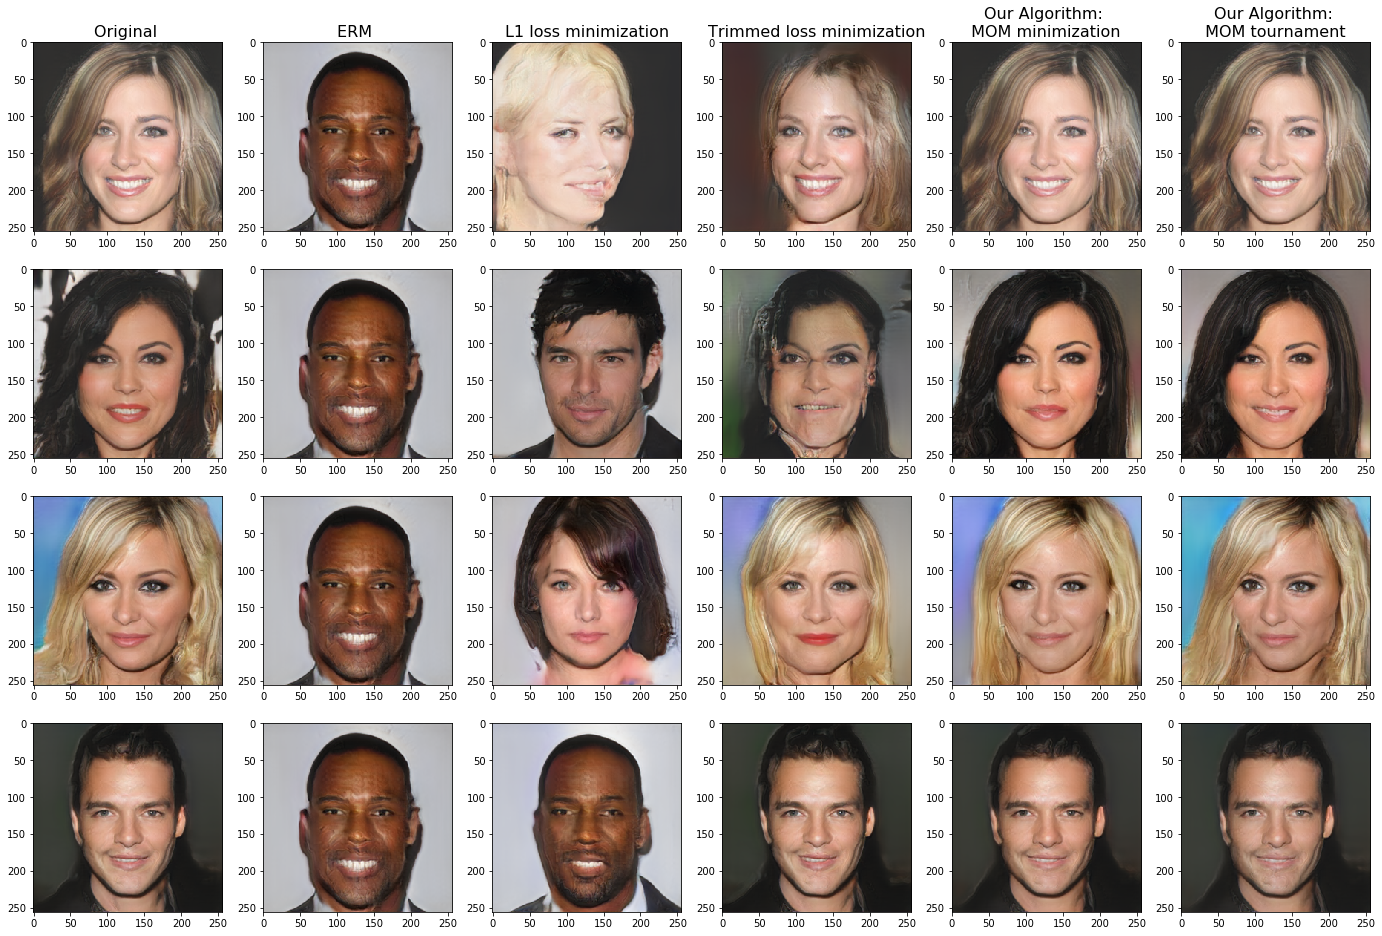

In [12]:
import matplotlib
import pickle

matplotlib.rc('font', size=10)
matplotlib.rc('axes', titlesize=16)


zz = 4

fig,ax = plt.subplots(zz, 6, figsize=(24,16))

for ii in range(zz):
    
    jj = ii + 2
        
    filename = "POST_" + str((jj) % 6 + 1) + ".pickle"
    
    with open(filename, 'rb') as f:        
        loaded_obj = pickle.load(f)

#     y = loaded_obj['y']
#     A = loaded_obj['A']
#     z0 = loaded_obj['z0']

    
    ax[ii, 0].imshow(scale(loaded_obj['f0']),cmap='gray')
    ax[ii, 1].imshow(scale(loaded_obj['f1']),cmap='gray')
    ax[ii, 2].imshow(scale(loaded_obj['f2']),cmap='gray')
    ax[ii, 3].imshow(scale(loaded_obj['f3']),cmap='gray')
    ax[ii, 4].imshow(scale(loaded_obj['f4']),cmap='gray')
    ax[ii, 5].imshow(scale(loaded_obj['f5']),cmap='gray')

    
    if ii == 0:
        ax[0, 0].set_title('Original ')
        ax[0, 1].set_title('ERM ')
        ax[0, 2].set_title('L1 loss minimization')
        ax[0, 3].set_title('Trimmed loss minimization')
        ax[0, 4].set_title('Our Algorithm: \n MOM minimization ')
        ax[0, 5].set_title('Our Algorithm: \n MOM tournament ')

plt.plot()

fig.savefig("CelebA-HQ.pdf", bbox_inches='tight')